# Определение перспективного тарифа для телеком компании

Целью данного проекта является проведение предварительного анализа тарифов «Смарт» и «Ультра» компании «Мегалайн» — федерального оператора сотовой связи. Для данного анализа в нашем распоряжении имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

**Задачи проекта:**

1. Провести предобработку данных для исследования, а именно:  

    - проверить данные на наличие дубликатов, обработать дубликаты
    - проверить данные на наличие пропусков и обработать данные пропуски
    - изменить тип данных, где это необходимо  
    
    
2. Дополнить данные необходимыми расчетами
3. Проанализировать данные и ответить на поставленные вопросы
4. Проверить гипотезы
5. Сделать общий вывод по результатам анализа

# Оглавление

1. [Загружаем библиотеки, изучаем данные](#1step)
2. [Подготовка данных](#2step)     
    2.1. [Исследуем значения длительности звонков и траффика](#2.1step)  
    2.2. [Изменим типы данных](#2.2step)  
    2.3. [Объединим данные](#2.3step)  
    2.4. [Дополним данные](#2.4step)  
3. [Анализ данных](#3step)  
4. [Проверка гипотез](#4step)  
    4.1. [Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается](#4.1step)  
    4.2. [Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#4.2step)  
5. [Общий вывод](#5step)

## Шаг 1. Загружаем библиотеки, изучаем данные. <a name="1step"></a>

Импортируем необходимые библиотеки:

In [1]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from scipy import stats as st

#библиотеки для визулизации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' %x)
pd.set_option('display.max_columns', 40)

Прочитаем файлы с данными и сохраним их в переменных calls, internet, messages, tariffs, users.

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv',index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Посмотрим на содержимое каждого датасета, выведем по 5 первых строк:

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [5]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


В нашем распоряжении имеется 5 датасетов, из них 3 содержат информацию о действиях пользователей, а именно о звонках (calls), сообщениях (messages) и используемом интернете (internet). Еще 2 датасета имеют справочный характер и содержат описание тарифа (tariffs) и подробную информацию о пользователях (users).

Посмотрим основную информацию о данных, в т.ч. типы данных по столбцам.

In [8]:
for data in [calls,internet,messages,tariffs,users]:
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

Метод describe применим только к таблицам с данными о звонках и интернете, т.к. таблица о сообщениях не содержит какой-либо количественной информации, а таблицы с тарифами и пользователями имеют описательный характер.

In [9]:
for data in [calls,internet]:
    display(data.describe())

,duration,user_id
count,202607.00,202607.00
mean,6.76,1253.94
std,5.84,144.72
min,0.00,1000.00
25%,1.30,1126.00
50%,6.00,1260.00
75%,10.70,1379.00
max,38.00,1499.00


,mb_used,user_id
count,149396.00,149396.00
mean,370.19,1252.10
std,278.30,144.05
min,0.00,1000.00
25%,138.19,1130.00
50%,348.01,1251.00
75%,559.55,1380.00
max,1724.83,1499.00


Сделаем первые выводы о данных и приступим к обработке:

1. Данные о звонках - таблица **calls**

    - содержит 202607 записей о звонках пользователей, пропуски отсутствуют
    - для столбцов *call_date* и *user_id* потребуется замена типа данных
    - значения в столбце *duration* могут принимать нулевые значения - необходимо разобраться в причине и обработать
 
 
2. Данные об интернете - таблица **internet**

    - содержит 149396 записей, пропуски отсутствуют
    - для столбцов *session_date* и *user_id* потребуется замена типа данных
    - значения в столбце *mb_used* могут принимать нулевые значения - необходимо разобраться в причине и обработать
    
    
3. Данные о сообщениях - таблица **messages**

    - содержит 123036 записи, пропуски отсутствуют 
    - для столбцов *message_date* и *user_id* потребуется замена типа данных
    
    
4. Информация о тарифах - таблица **tariffs**

    - содержит информацию о двух тарифах компании в следующих столбцах:
    - замена типов данных не требуется


5. Информация о пользователях - таблица **users**

    - содержит информацию о 500 пользователях компании в следующих столбцах:
    - для столбцов *reg_date* и *user_id* потребуется замена типа данных
    - присутствуют пропуски в столбце *churn_date*, связанные с тем, что пользователи с пропущенными значениями не прекратили пользоваться тарифов на момент выгрузки

## Вывод

Имеющиеся файлы с данными содержат всю необходимую информацию, позволяющую провести предварительный анализа тарифов компании «Мегалайн».

Прежде чем приступить к исследованию данных, необходимо будет провести предобработку, а именно:
* исследовать нулевые значения в длительности звонка и объема потраченного интернета. Это может быть связано с тем, что пользователь не дозвонился, либо пользователь подключил мобильный интернет, но не успел загрузить страницу и выключил.  
* заменить типы данных в указаных выше столбцах
* объединить датасеты для удобства в дальнейшем исследовании



# Шаг 2. Подготовка данных. <a name="2step"></a>

## 2.1. Исследуем значения длительности звонков и траффика <a name="2.1step"></a>

Исследуем нулевые значения в длительности звонка и объема потраченного интернета:

In [10]:
print('Всего звонков с любой длительностью:',len(calls),', совершенных',len(calls['user_id'].unique()),'пользователями')
print('Всего звонков с длительностью 0 минут:',len(calls.query('duration == 0')),', совершенных',\
     len(calls.query('duration == 0')['user_id'].unique()),'пользователями')
print('Доля звонков с длительностью 0 минут: {:.2%}'.format(len(calls.query('duration == 0')) / len(calls)))

Всего звонков с любой длительностью: 202607 , совершенных 492 пользователями
Всего звонков с длительностью 0 минут: 39613 , совершенных 492 пользователями
Доля звонков с длительностью 0 минут: 19.55%


Итак, каждый из 492 пользователей, совершающих звонки, совершал звонки с длительностью 0 минут. Если бы такая длительность была установлена для 1-2 пользователей (для крайне малой доли), это бы вызвало сомнения о корректности данных для этих пользователей. Однако поскольку нулевая длительность наблюдается у каждого пользователя, то вероятно наше предположение о том, что это недозвоны, верно. Краткий ресерч данной темы в интернете также подтвердил, что существует такая особенность у некоторых операторов, особенно при звонках на телефоны других операторов, у который срабатывает голосовая почта.

Проверим, верно ли оно для интернета:

In [11]:
print('Всего сессий интернета:',len(internet),', совершенных',len(internet['user_id'].unique()),'пользователями')
print('Всего сессий интернета с нулевым объемом:',len(internet.query('mb_used == 0')),', совершенных',\
     len(internet.query('mb_used == 0')['user_id'].unique()),'пользователями')
print('Доля сессий интернета с нулевым объемом: {:.2%}'.format(len(internet.query('mb_used == 0')) / len(internet)))

Всего сессий интернета: 149396 , совершенных 497 пользователями
Всего сессий интернета с нулевым объемом: 19598 , совершенных 494 пользователями
Доля сессий интернета с нулевым объемом: 13.12%


Для интернета ситуация практически идентичная. Почти 100% пользователей имеют сессии с нулевым объемом интернет-трафика.

Для дальнейшего исследования округлим нулевые значения до 1. Также мы знаем, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Поэтому применим округление вверх для всех значений.

In [12]:
#округляем все значения вверх
calls['duration_round'] = calls['duration'].apply(np.ceil)
#округляем оставшиеся нулевые значения до единицы
calls.loc[calls['duration_round'] == 0,'duration_round'] = 1
calls.head()

,id,call_date,duration,user_id,duration_round
0,1000_0,2018-07-25,0.00,1000,1.00
1,1000_1,2018-08-17,0.00,1000,1.00
2,1000_2,2018-06-11,2.85,1000,3.00
3,1000_3,2018-09-21,13.80,1000,14.00
4,1000_4,2018-12-15,5.18,1000,6.00


In [13]:
internet['mb_used_round'] = internet['mb_used'].apply(np.ceil)
internet.loc[internet['mb_used_round'] == 0,'mb_used_round'] = 1
internet.head()

,id,mb_used,session_date,user_id,mb_used_round
0,1000_0,112.95,2018-11-25,1000,113.00
1,1000_1,1052.81,2018-09-07,1000,1053.00
2,1000_2,1197.26,2018-06-25,1000,1198.00
3,1000_3,550.27,2018-08-22,1000,551.00
4,1000_4,302.56,2018-09-24,1000,303.00


## 2.2. Изменим типы данных <a name="2.2step"></a>

Нам необходимо заменить тип данных в столбцах с датами на формат даты и в столбце с user_id на формат object, поскольку нам не нужно проводить математические операции с id пользователей.

Изменим тип данных в столбцах с датами:

In [14]:
def date_type(df):
    for column in df.columns:
        if 'date' in column:
            df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

date_type(calls)
date_type(internet)
date_type(messages)
date_type(users)

Изменим тип данных в столбце с user_id:

In [15]:
def user_id_type(df):
    for column in df.columns:
        if 'user_id' in column:
            df[column] = df[column].astype('object')

user_id_type(calls)
user_id_type(internet)
user_id_type(messages)
user_id_type(users)

## 2.3. Объединим данные <a name="2.3step"></a>

Для дальнейшего исследования имеет смысл объединить 3 датасета calls, messages и internet. Перед объединением сделаем некоторые преобразования: 
1. переименуем столбцы с одинаковым названием id, поскольку в каждой таблице данный столбец имеет разный смысл
2. добавим информацию о месяцах, поскольку нам не столько важны даты, сколько важны месяцы
3. сгруппируем таблицы по user_id и месяцам

**1. Переименовываем столбцы**

In [16]:
calls.columns = ['call_id', 'call_date', 'duration', 'user_id', 'duration_round']

internet.columns = ['internet_id', 'mb_used', 'session_date', 'user_id','mb_used_round']

messages.columns = ['message_id', 'message_date', 'user_id']

**2. Добавляем столбцы с месяцем. Добавим не просто месяц, а месяц + год, для этого приведем все даты к 1 числу месяца.**

In [17]:
def add_month(df):
    for column in df.columns:
        if 'date' in column:
            df['month'] = df[column].values.astype('datetime64[M]')
            
add_month(calls)
add_month(internet)
add_month(messages)

**3. Сгруппируем таблицы**

In [18]:
calls_month = (calls.groupby(['user_id','month'])[['call_id','duration','duration_round']]
                   .agg({'call_id':'count','duration':'sum','duration_round':'sum'})
                   .reset_index()
              )
calls_month.columns=['user_id','month','calls_amount','calls_duration','calls_duration_round']
calls_month

,user_id,month,calls_amount,calls_duration,calls_duration_round
0,1000,2018-05-01,22,150.06,164.00
1,1000,2018-06-01,43,158.90,187.00
2,1000,2018-07-01,47,318.80,346.00
3,1000,2018-08-01,52,389.87,418.00
4,1000,2018-09-01,58,440.14,478.00
...,...,...,...,...,...
3169,1498,2018-10-01,41,232.63,258.00
3170,1499,2018-09-01,9,64.65,71.00
3171,1499,2018-10-01,68,429.91,473.00
3172,1499,2018-11-01,74,576.50,624.00


In [19]:
internet_month = (internet.groupby(['user_id','month'])[['internet_id','mb_used','mb_used_round']]
                          .agg({'internet_id':'count','mb_used':'sum','mb_used_round':'sum'})
                          .reset_index()
                 )
internet_month.columns=['user_id','month','sessions_amount','mb_used','mb_used_round']
internet_month

,user_id,month,sessions_amount,mb_used,mb_used_round
0,1000,2018-05-01,5,2253.49,2257.00
1,1000,2018-06-01,49,23233.77,23262.00
2,1000,2018-07-01,29,14003.64,14017.00
3,1000,2018-08-01,29,14055.93,14072.00
4,1000,2018-09-01,27,14568.91,14583.00
...,...,...,...,...,...
3198,1498,2018-10-01,59,20579.36,20614.00
3199,1499,2018-09-01,5,1845.75,1849.00
3200,1499,2018-10-01,58,17788.51,17824.00
3201,1499,2018-11-01,49,17963.31,17994.00


In [20]:
messages_month = (messages.groupby(['user_id','month'])['message_id']
                         .agg({'message_id':'count'}).reset_index())
messages_month.columns=['user_id','month','messages_amount']
messages_month

,user_id,month,messages_amount
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
...,...,...,...
2712,1498,2018-10-01,42
2713,1499,2018-09-01,11
2714,1499,2018-10-01,48
2715,1499,2018-11-01,59


Теперь в нашем распоряжении есть три таблицы, в которых собрана информация о количестве и длительности звонков, количестве интернет-сессий и объеме траффика, а также о количестве отправленных смс для пользователей. 

Далее возьмем таблицу с данными о пользователях. Добавим к этой таблице месяцы, чтобы затем объединить полученную таблицу с таблицами о звонках, интернете и сообщениях.

In [21]:
calls_month['month'].agg({'min','max'})

max   2018-12-01
min   2018-01-01
Name: month, dtype: datetime64[ns]

In [22]:
internet_month['month'].agg({'min','max'})

max   2018-12-01
min   2018-01-01
Name: month, dtype: datetime64[ns]

In [23]:
messages_month['month'].agg({'min','max'})

max   2018-12-01
min   2018-01-01
Name: month, dtype: datetime64[ns]

In [24]:
min_month = '2018-01-01'
max_month = '2018-12-01'

Проверили, что для всех данных у нас единый временной интервал: с января по декабрь 2018 г. Добавим эти даты к урезанной таблице о пользователях. У нас должно получиться 500 (пользователей) * 12 (месяцев) = 6000 строк.

In [25]:
dates = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))
dates.columns=['month']

In [26]:
users['key'] = 1
dates['key'] = 1

In [27]:
users = users.merge(dates,on='key')
len(users)

6000

In [28]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,key,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-01-01
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-02-01
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-03-01
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-04-01
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-05-01
...,...,...,...,...,...,...,...,...,...,...
5995,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1,2018-08-01
5996,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1,2018-09-01
5997,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1,2018-10-01
5998,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1,2018-11-01


In [29]:
full_data = users.merge(calls_month,on=['user_id','month'],how='left')
full_data = full_data.merge(internet_month,on=['user_id','month'],how='left')
full_data = full_data.merge(messages_month,on=['user_id','month'],how='left')

In [30]:
full_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,key,month,calls_amount,calls_duration,calls_duration_round,sessions_amount,mb_used,mb_used_round,messages_amount
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-01-01,nan,nan,nan,nan,nan,nan,nan
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-02-01,nan,nan,nan,nan,nan,nan,nan
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-03-01,nan,nan,nan,nan,nan,nan,nan
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-04-01,nan,nan,nan,nan,nan,nan,nan
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-05-01,22.00,150.06,164.00,5.00,2253.49,2257.00,22.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1,2018-08-01,nan,nan,nan,nan,nan,nan,nan
5996,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1,2018-09-01,9.00,64.65,71.00,5.00,1845.75,1849.00,11.00
5997,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1,2018-10-01,68.00,429.91,473.00,58.00,17788.51,17824.00,48.00
5998,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1,2018-11-01,74.00,576.50,624.00,49.00,17963.31,17994.00,59.00


Итак, мы получили таблицу, в которой по каждому пользователю и по каждому месяцу можно посмотреть информацию о звонках, сообщениях и интернете. Проверим, что все было сделано корректно и финальная таблица по цифрам соответствует начальным датасетам.

In [31]:
print(calls['duration'].sum())
print(full_data['calls_duration'].sum())

1368790.0399999998
1368790.04


In [32]:
print(internet['mb_used'].sum())
print(full_data['mb_used'].sum())

55305267.73
55305267.73


In [33]:
print(messages['message_id'].count())
print(full_data['messages_amount'].sum())

123036
123036.0


Данные были объединены корректно. Заполним пропуски в данных, отображающихся сейчас, как NaN на нули.

In [34]:
full_data[['calls_amount',
       'calls_duration', 'calls_duration_round', 'sessions_amount', 'mb_used',
       'mb_used_round', 'messages_amount']] = full_data[['calls_amount',
       'calls_duration', 'calls_duration_round', 'sessions_amount', 'mb_used',
       'mb_used_round', 'messages_amount']].fillna(0)

In [35]:
full_data = full_data.drop(columns='key')

Для дальнейших расчетов нам также понадобится информация о тарифах, объединим и ее с получившейся итоговой таблицей:

In [36]:
full_data.columns = ['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name', 'month', 'calls_amount', 'calls_duration',
       'calls_duration_round', 'sessions_amount', 'mb_used', 'mb_used_round',
       'messages_amount']

In [37]:
full_data = full_data.merge(tariffs,on='tariff_name',how='left')

Некоторые клиенты зарегистрировались на использование тарифа не с самого первого дня года, а позже и также есть клиенты, которые прекратили использование тарифа в течение года. Сейчас строки с месяцами, в которых пользователь не был подключен к тарифу, все равно есть в таблице. Однако это ее утяжеляет и может потенциально привести к ошибкам в расчетах. 

Предположим, что ежемесячная тарифная плата начисляется начиная с месяца, в котором был зарегистрирован пользователь. То есть если дата подключения тарифа (*reg_date*) - 25 января 2018 года, то в январе на пользователя будет начислена ежемесячная абонентская плата в полном размере. 

Также предположим, что выручка прекращает начисляться с 1го числа месяца, следующего за месяцем окончания пользования тарифом. То есть если дата отключения от тарифа (*churn_date*) - 05 октября 2018 года, то за октябрь ежемесячная абонентская плата все равно будет начислена, но за ноябрь - нет.

Для расчета выручки добавим столбцы, в которых для каждого пользователя будет указана дата старта начисления выручки (*revenue_start_date*) и дата окончания начисления выручки (*revenue_stop_date*). Затем добавим столбец *month_count*, в котором будет указана 1 - если за этот месяц будет начисляться выручка или 0 - если не будет.

In [38]:
full_data['revenue_start_date'] = full_data['reg_date'] + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

full_data['revenue_stop_date'] = full_data['churn_date'] + pd.offsets.MonthEnd(0)

In [39]:
def month_count(row):
    if row['revenue_start_date'] > row['month'] or row['revenue_stop_date'] < row['month']:
            return 0
    else:
        return 1

full_data['month_count'] = full_data.apply(month_count, axis=1)   

Оставим для дальнейшего исследования только те строки, в которых *month_count* равен 1, то есть клиент использовал тариф и мы будем начислять на него как минимум абоненсткую плату.

In [40]:
full_data = full_data.query('month_count == 1')

Посмотрим, как выглядит полученная таблица и выведем по ней основную информацию:

In [41]:
full_data.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,month,calls_amount,calls_duration,calls_duration_round,sessions_amount,mb_used,mb_used_round,messages_amount,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_start_date,revenue_stop_date,month_count
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,22.00,150.06,164.00,5.00,2253.49,2257.00,22.00,1000,30720,3000,1950,150,1,1,2018-05-01,NaT,1
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,43.00,158.90,187.00,49.00,23233.77,23262.00,60.00,1000,30720,3000,1950,150,1,1,2018-05-01,NaT,1
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,47.00,318.80,346.00,29.00,14003.64,14017.00,75.00,1000,30720,3000,1950,150,1,1,2018-05-01,NaT,1
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,52.00,389.87,418.00,29.00,14055.93,14072.00,81.00,1000,30720,3000,1950,150,1,1,2018-05-01,NaT,1
8,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,58.00,440.14,478.00,27.00,14568.91,14583.00,57.00,1000,30720,3000,1950,150,1,1,2018-05-01,NaT,1
9,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-10-01,57.00,328.45,363.00,27.00,14702.49,14717.00,73.00,1000,30720,3000,1950,150,1,1,2018-05-01,NaT,1
10,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-11-01,43.00,319.04,344.00,24.00,14756.47,14769.00,58.00,1000,30720,3000,1950,150,1,1,2018-05-01,NaT,1
11,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-12-01,46.00,312.98,341.00,21.00,9817.61,9829.00,70.00,1000,30720,3000,1950,150,1,1,2018-05-01,NaT,1
22,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01,59.00,408.12,444.00,55.00,18429.34,18460.00,0.00,50,15360,500,550,200,3,3,2018-11-01,NaT,1
23,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2018-12-01,63.00,391.34,430.00,41.00,14036.66,14059.00,0.00,50,15360,500,550,200,3,3,2018-11-01,NaT,1


In [42]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 4 to 5999
Data columns (total 26 columns):
user_id                  3216 non-null object
age                      3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff_name              3216 non-null object
month                    3216 non-null datetime64[ns]
calls_amount             3216 non-null float64
calls_duration           3216 non-null float64
calls_duration_round     3216 non-null float64
sessions_amount          3216 non-null float64
mb_used                  3216 non-null float64
mb_used_round            3216 non-null float64
messages_amount          3216 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null

In [43]:
full_data.describe()

,age,calls_amount,calls_duration,calls_duration_round,sessions_amount,mb_used,mb_used_round,messages_amount,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month_count
count,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00,3216.00
mean,46.64,63.00,425.62,463.28,46.45,17196.91,17222.97,38.26,341.26,20069.25,1266.48,979.23,184.67,2.39,2.39,1.00
std,16.58,33.26,228.74,248.11,18.89,7580.75,7589.03,36.15,438.09,7083.27,1152.88,645.61,23.06,0.92,0.92,0.00
min,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,15360.00,500.00,550.00,150.00,1.00,1.00,1.00
25%,32.00,40.00,267.11,290.75,35.00,12478.77,12503.25,9.00,50.00,15360.00,500.00,550.00,150.00,1.00,1.00,1.00
50%,46.00,62.00,417.70,456.00,48.00,16937.82,16966.00,30.00,50.00,15360.00,500.00,550.00,200.00,3.00,3.00,1.00
75%,62.00,82.00,554.91,605.00,59.00,21422.38,21450.50,57.00,1000.00,30720.00,3000.00,1950.00,200.00,3.00,3.00,1.00
max,75.00,244.00,1578.06,1727.00,118.00,49745.69,49793.00,224.00,1000.00,30720.00,3000.00,1950.00,200.00,3.00,3.00,1.00


## 2.4. Дополним данные <a name="2.4step"></a>

Итак, у нас уже есть по каждому пользователю:
* количество сделанных звонков и израсходованных минут разговора по месяцам - столбцы *calls_amount* и *calls_duration_round*;
* количество отправленных сообщений по месяцам - столбец *messages_amount*;
* объем израсходованного интернет-трафика по месяцам - столбец *mb_used_round*;

Посчитаем:
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Здесь и далее в расчетах будем использовать округленные значения длительности звонков и объема интернета, поскольку тариффикация происходит именно таким образом, с округлением вверх.

In [44]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Добавим в таблицу столбцы, в которых будут отображаться израсходованные звонки, мегабайты и сообщения сверх лимита по тарифу.

In [45]:
def over_limit_minutes(row):
    if (row['calls_duration_round'] - row['minutes_included']) > 0:
        return (row['calls_duration_round'] - row['minutes_included'])
    else:
        return 0
    
full_data['over_limit_minutes'] = full_data.apply(over_limit_minutes, axis=1)

In [46]:
def over_limit_mb(row):
    if (row['mb_used_round'] - row['mb_per_month_included']) > 0:
        return (row['mb_used_round'] - row['mb_per_month_included'])
    else:
        return 0
    
full_data['over_limit_gb'] = (full_data.apply(over_limit_mb, axis=1) / 1024).apply(np.ceil)

In [47]:
def over_limit_messages(row):
    if (row['messages_amount'] - row['messages_included']) > 0:
        return (row['messages_amount'] - row['messages_included'])
    else:
        return 0
    
full_data['over_limit_messages'] = full_data.apply(over_limit_messages, axis=1)

Подговительные работы закончены, считаем выручку:

In [48]:
def revenue(row):
    if row['month_count'] == 1:
        return row['rub_monthly_fee'] + \
                   row['over_limit_minutes'] * row['rub_per_minute'] +\
                   row['over_limit_gb'] * row['rub_per_gb'] +\
                   row['over_limit_messages'] * row['rub_per_message']
    else:
        return 0

full_data['revenue'] = full_data.apply(revenue, axis=1)       

Такие столбцы, как *age*, *first_name*, *last_name*, а также столбцы с информацией о тарифе больше не понадобятся нам для дальнейшего анализа. Оставим в таблице только необходимую информацию и перейдем к исследованию:

In [49]:
full_data.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name', 'month', 'calls_amount', 'calls_duration',
       'calls_duration_round', 'sessions_amount', 'mb_used', 'mb_used_round',
       'messages_amount', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute', 'revenue_start_date', 'revenue_stop_date',
       'month_count', 'over_limit_minutes', 'over_limit_gb',
       'over_limit_messages', 'revenue'],
      dtype='object')

In [50]:
full_data = full_data.drop(columns=['age','churn_date', 'first_name', 'last_name',
       'reg_date','messages_included', 'mb_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute', 'revenue_start_date', 'revenue_stop_date'])

In [51]:
full_data.head()

,user_id,city,tariff_name,month,calls_amount,calls_duration,calls_duration_round,sessions_amount,mb_used,mb_used_round,messages_amount,month_count,over_limit_minutes,over_limit_gb,over_limit_messages,revenue
4,1000,Краснодар,ultra,2018-05-01,22.00,150.06,164.00,5.00,2253.49,2257.00,22.00,1,0.00,0.00,0.00,1950.00
5,1000,Краснодар,ultra,2018-06-01,43.00,158.90,187.00,49.00,23233.77,23262.00,60.00,1,0.00,0.00,0.00,1950.00
6,1000,Краснодар,ultra,2018-07-01,47.00,318.80,346.00,29.00,14003.64,14017.00,75.00,1,0.00,0.00,0.00,1950.00
7,1000,Краснодар,ultra,2018-08-01,52.00,389.87,418.00,29.00,14055.93,14072.00,81.00,1,0.00,0.00,0.00,1950.00
8,1000,Краснодар,ultra,2018-09-01,58.00,440.14,478.00,27.00,14568.91,14583.00,57.00,1,0.00,0.00,0.00,1950.00


## Вывод

Итак, к данному этапу данные обработаны, а именно:
1. Были исследованы значения длительности звонка и объема интернет-трафика, было принято решение об округлении значений вверх в связи с особенностями тарификации.  
2. Типы данных были изменены, что упростит работу с данными при дальнейшем анализе.  
3. Данные, которые изначельно содержались в разных таблицах, были объеденены в одну, что позволило производить дальнейшие расчеты.
4. Были добавлены дополнительные расчеты, которые будут использоваться для проверки гипотез.

# Шаг 3. Анализ данных. <a name="3step"></a>

**Задача:**
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Наша выборка включает данные об активности 500 пользователей двух тарифов в течение 2018 года. Не каждый пользователь пользовался тарифом 12 месяцев, некоторые пользователи подключились в середине года, некоторые прекратили использовать тариф в один из месяцев.

In [52]:
full_data['month_count'].sum() / full_data['user_id'].nunique()

6.432

In [53]:
tariffs_overview = (full_data
                     .pivot_table(index='tariff_name',values=['month_count','user_id']
                                        ,aggfunc=({'month_count':'sum','user_id':'nunique'}))
                     .reset_index()
                  )
tariffs_overview['average_months'] = tariffs_overview['month_count'] / tariffs_overview['user_id']
tariffs_overview

,tariff_name,month_count,user_id,average_months
0,smart,2230,351,6.35
1,ultra,986,149,6.62


В среднем пользователи использовали тарифы "Смарт" и "Ультра" в течение чуть менее 6,5 месяцев в течение 2018 года. Если смотреть раздельно по тарифам, то среднее количество месяцев использования для тарифа "Ультра" немного больше, чем для тарифа "Смарт". Однако при этом количество пользователей тарифа "Ультра" составляет только 30% от всех пользоваталей.

Соберем в единую таблицу по каждому пользователю информацию о звонках, объеме интернета и количестве сообщений.

In [54]:
tariffs_details = (full_data
                            .groupby(['tariff_name','user_id','month'])
                                   [['calls_duration_round','mb_used_round','messages_amount']].sum()
                            .reset_index()
                  )
tariffs_details

,tariff_name,user_id,month,calls_duration_round,mb_used_round,messages_amount
0,smart,1001,2018-11-01,444.00,18460.00,0.00
1,smart,1001,2018-12-01,430.00,14059.00,0.00
2,smart,1002,2018-06-01,118.00,10878.00,4.00
3,smart,1002,2018-07-01,219.00,17615.00,11.00
4,smart,1002,2018-08-01,294.00,20357.00,13.00
...,...,...,...,...,...,...
3211,ultra,1495,2018-08-01,96.00,2616.00,13.00
3212,ultra,1495,2018-09-01,830.00,33107.00,82.00
3213,ultra,1495,2018-10-01,1056.00,29399.00,82.00
3214,ultra,1495,2018-11-01,971.00,38973.00,79.00


In [55]:
tariffs_stat = tariffs_details.pivot_table(index=['tariff_name'], values=['calls_duration_round', 'mb_used_round', 'messages_amount'], 
                    aggfunc={'calls_duration_round': [np.mean, np.median, np.var, np.std], 
                             'mb_used_round': [np.mean, np.median, np.var, np.std], 
                             'messages_amount': [np.mean, np.median, np.var, np.std]})
tariffs_stat

calls_duration_round                         mb_used_round  \
                            mean median    std       var          mean   
tariff_name                                                              
smart                     429.26 434.50 195.04  38040.44      16229.90   
ultra                     540.23 531.50 326.03 106294.60      19468.94   

                                           messages_amount               \
              median      std          var            mean median   std   
tariff_name                                                               
smart       16538.00  5888.52  34674707.98           33.37  28.00 28.23   
ultra       19320.50 10111.05 102233278.94           49.31  38.00 47.81   

                     
                var  
tariff_name          
smart        796.96  
ultra       2285.42

Итак, в таблице мы видим описательные статистики для каждого тарифа: среднее арифметическое, медиану, стандартное отклонение и дисперсию.

Мы видим, что среднее значение и медиана по длительности звонков, объеме интернета и количестве смс для тарифа "Смарт" ниже, чем для тарифа "Ультра". 
Вспомним, что включает в себя каждый тариф:
* "Смарт" - включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика. Ежемес. плата - 550 руб.
* "Ультра" - включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика. Ежемес. плата - 1950 руб.

Очевидно, что если пользователь подключает тариф "Ультра", абонентская плата которого в 3,5 раза дороже, чем у тарифа "Смарт", то у пользователя есть спрос на бОльшее количество минут, сообщений и объема интернет-трафика. 

Однако можно заметить, что если у тарифа "Смарт":
* среднее количество минут, составляющее 430 минут, близко к лимиту в 500 минут
* средний объем интернет-трафика, составляющий 15,8 Гб, что даже превышает лимит в 15 Гб
* среднее количество отправленных смс, составляющее 33 сообщения при лимите в 50 сообщений

Т.е. в среднем пользователи тарифа "выбирают" или почти "выбирают" пакет полностью. То для тарифа "Ультра":
* среднее кол-во минут - 541 минута, при лимите в 3000 минут
* средний объем трафика - 19 Гб, при лимите в 30 Гб
* среднее кол-во смс - 49 сообщений, при лимите в 1000 сообщений.

Пользователи тарифа "Ультра" в среднем используют гораздо меньшее количество услуг, чем им предоставляют в пакете.

Однако в таблице с описательными статистиками можно заметить, что стандартное отклонение для тарифа "Ультра" больше, чем для тарифа "Смарт". Можно предположить, что распределение для пользователей тарифа "Ультра" будет более широким, а для пользователей тарифа "Смарт" - более узким.

Проверим, верно ли наше предположение:

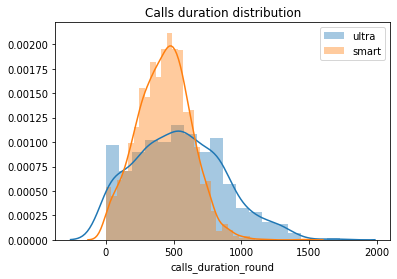

In [56]:
for tariff in ['ultra', 'smart']:
    sns.distplot(tariffs_details.query('tariff_name == @tariff')['calls_duration_round'],label=tariff)
    plt.legend(['ultra', 'smart'])
    plt.title('Calls duration distribution');

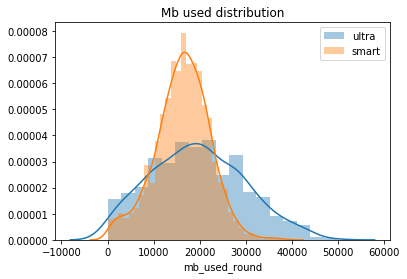

In [57]:
for tariff in ['ultra', 'smart']:
    sns.distplot(tariffs_details.query('tariff_name == @tariff')['mb_used_round'], label=tariff)
    plt.legend(['ultra', 'smart'])
    plt.title('Mb used distribution');

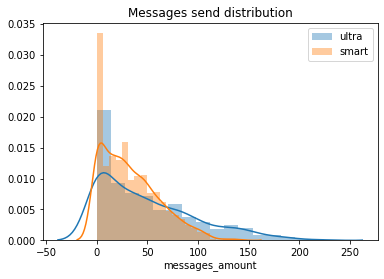

In [58]:
for tariff in ['ultra', 'smart']:
    sns.distplot(tariffs_details.query('tariff_name == @tariff')['messages_amount'], label=tariff)
    plt.legend(['ultra', 'smart'])
    plt.title('Messages send distribution');

Наше предположение оказалось верным: распределение длительности звонков, объема интернет-трафика, количества смс для тарифа "Смарт" более узкое, чем для тарифа "Ультра". Пользователи тарифа "Ультра" имеют большой пакет услуг и, соответственно, большее "поле для маневров".

Интересно, что достаточно большая часть пользователей тарифа "Смарт" (но меньше половины) выходит за лимиты пакета по звонкам, примерно половина пользователей выходит за лимиты пакета интернета. При этом смс не пользуется популярностью у пользователей тарифа.

Для тарифа "Ультра" ситуация по звонкам совершенно иная - из нашей выборки ни один из пользователей тарифа "Ультра" не достиг лимита по звонкам. При этом интернета пользователям тарифа не всегда хватает - на графике видно, что часть пользователей превышает лимит в 30 Гб (30720 Мб). Сообщения для пользователей тарифа также не актуальны.

Что касается типа распределения, то распределение длительности звонков и объема трафика выглядит похожим на нормальное распределение, однако с отрезанными левыми хвостами в районе 0 минут и 0 Мб. Также распределения имеют небольшую скошенность влево.

Что касается распределения количества смс, то данное распределение по своему виду визуально напоминает распределение Пуассона.

Еще одним наглядным инструментом для визуализации данных будет boxplot:

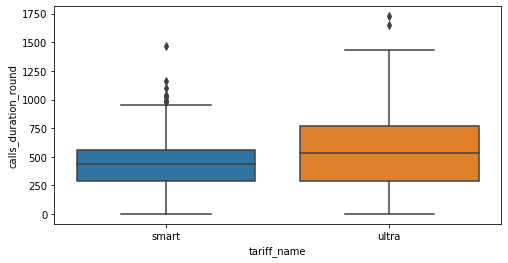

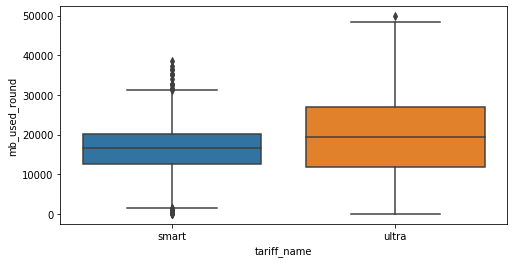

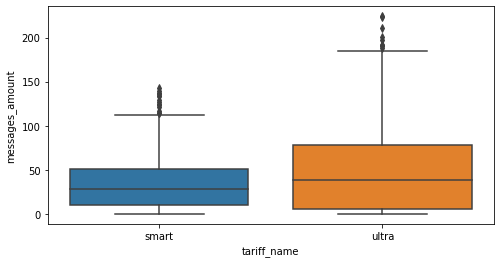

In [59]:
for col in ['calls_duration_round','mb_used_round','messages_amount']:
    plt.figure(figsize=(8,4));''
    sns.boxplot(data=tariffs_details, x='tariff_name', y=col);
    plt.show();

А распределение, совмемещенное с диаграммой размаха позволит увидеть violinplot:

In [77]:
tariffs_details

,tariff_name,user_id,month,calls_duration_round,mb_used_round,messages_amount
0,smart,1001,2018-11-01,444.00,18460.00,0.00
1,smart,1001,2018-12-01,430.00,14059.00,0.00
2,smart,1002,2018-06-01,118.00,10878.00,4.00
3,smart,1002,2018-07-01,219.00,17615.00,11.00
4,smart,1002,2018-08-01,294.00,20357.00,13.00
...,...,...,...,...,...,...
3211,ultra,1495,2018-08-01,96.00,2616.00,13.00
3212,ultra,1495,2018-09-01,830.00,33107.00,82.00
3213,ultra,1495,2018-10-01,1056.00,29399.00,82.00
3214,ultra,1495,2018-11-01,971.00,38973.00,79.00


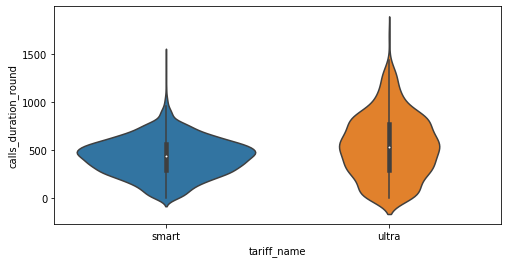

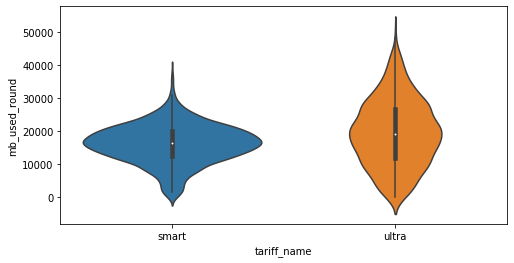

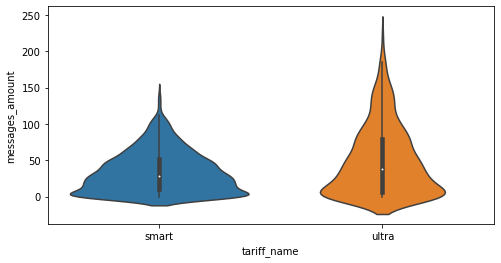

In [78]:
for col in ['calls_duration_round','mb_used_round','messages_amount']:
    plt.figure(figsize=(8,4));
    sns.violinplot(data=tariffs_details, x='tariff_name', y=col);
    plt.show();

На гистограммах было не так явно заметно, что количество выбросов для тарифа "Смарт" больше, чем для тарифа "Ультра". Также мы наглядно видим, что медиана для тарифа "Ультра" выше, чем для тарифа "Смарт".

## Вывод

На основании проведенного анализа данных о поведении 500 пользователей тарифов компании "Мегалайн", можно сделать такие выводы:

1. Средний пользователь тарифа "Смарт" за месяц использует 430 минут звонков, 15,8 Гб интернета и 33 сообщения. При этом достаточно большой части пользователей недостаточно предлагаемого пакета и они выходят за рамки лимитов, то есть платят дополнительно, в основном за звонки и интернет, сообщения не так необходимы для клиентов. Для данного тарифа мы наблюдаем большое количество выбросов, особенно по использованному объему интернета. Вероятно, что для определенной доли пользователей тарифа "Смарт" было бы дешевле перейти на тариф "Ультра".  


2. Средний пользователь тарифа "Ультра" за месяц использует 541 минуту звонков, 19 Гб интернета и 49 сообщений. Интересно, что ни один из клиентов за 2018 год не достиг лимита по звонкам и сообщениям, однако есть пользователи, которым требовался дополнительный объем интернета. Возможно несмотря на то, что большинство пользователей тарифа не достигает лимита, тем не менее для них важно иметь большой пакет услуг и они платят бОльшую абонентскую плату за возможность не переживать о том, что они превысят лимит.

# Шаг 4. Проверка гипотез. <a name="4step"></a>

## 4.1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается <a name="4.1step"></a>

Сформулируем гипотезы:

**H₀**: выручка пользователей тарифов "Ультра" и "Смарт" равна  
**H₁**: выручка пользователей тарифов не равна

Проверять гипотезы будем при уровне значимости равном 5%.

Нам необходимо проверить, значима ли разница между средней выручкой пользователей тарифа "Смарт" и "Ультра"? Или же различия могут быть получены случайно?

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind (array1, array2, equal_var), t-теста . У нас нет оснований полагать, что выборки взяты из схожих по параметрам ген совокупностей, так как выборки взяты по двум разным по параметрам тарифам, поэтому параметр equal_var передадим, как equal_var = False.

In [61]:
tariffs_revenue = (full_data
                            .groupby(['tariff_name','user_id','month'])
                                   ['revenue'].sum()
                            .reset_index()
                  )
tariffs_revenue

,tariff_name,user_id,month,revenue
0,smart,1001,2018-11-01,1350.00
1,smart,1001,2018-12-01,550.00
2,smart,1002,2018-06-01,550.00
3,smart,1002,2018-07-01,1150.00
4,smart,1002,2018-08-01,1550.00
...,...,...,...,...
3211,ultra,1495,2018-08-01,1950.00
3212,ultra,1495,2018-09-01,2400.00
3213,ultra,1495,2018-10-01,1950.00
3214,ultra,1495,2018-11-01,3300.00


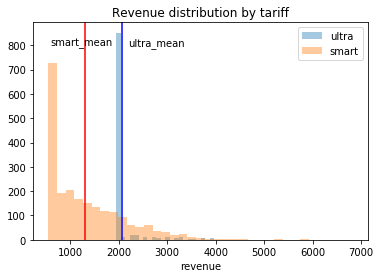

In [62]:
for tariff in ['ultra', 'smart']:
    sns.distplot(tariffs_revenue.query('tariff_name == @tariff')['revenue'],label=tariff, kde=False)
    plt.legend(['ultra', 'smart'])
    plt.title('Revenue distribution by tariff');

plt.axvline(tariffs_revenue.query('tariff_name == "smart"')['revenue'].mean(), c='red');
plt.axvline(tariffs_revenue.query('tariff_name == "ultra"')['revenue'].mean(), c='blue');
plt.text(600,800, "smart_mean")
plt.text(2200,800, "ultra_mean")
plt.show()

На графике мы видим, что и у тарифа "Смарт" и у тарифа "Ультра" наблюдается пик в точке минимальной абоненской платы - 550 руб. и 1950 руб., соответственно.

Однако при этом среднее значение выручки тарифа "Смарт" находится дальше этого минимального значения, что объясняется длинным хвостом с высокими значениями. Как мы уже выявили раньше, средний пользователь тарифа "Смарт" использует практически полностью пакет звонков и даже превышает пакет интернета. При этом стоимость звонков и интернета сверх лимита достаточно дорогая - 3 руб./минута и 200 руб./1 Гб. Таким образом, можно сделать вывод о том, что достаточно большому количеству пользователей тарифа "Смарт" не хватает пакета, предлагаемого этим тарифом. Среднее значение выручки по тарифу "Смарт" составляет 1313 руб., медиана - 1077 руб. 

Среднее значение выручки тарифа "Ультра" находится совсем немного дальше минимального значения, т.е. абонентской платы и составляет 2071 руб., при этом медиана равна абоненсткой плате - 1950 руб. То есть большинству пользователей тарифа "Ультра" достаточно предоставляемого с тарифом пакета и они реже, чем пользователи тарифа "Смарт" приобретают услуги сверх лимита.

In [63]:
(tariffs_revenue
         .pivot_table(index='tariff_name',values='revenue',aggfunc=({'sum','count','mean','median'}))
)

,count,mean,median,sum
tariff_name,,,,
smart,2230,1312.17,1075.00,2926140.00
ultra,986,2070.94,1950.00,2041950.00


In [64]:
smart = tariffs_revenue.query('tariff_name == "smart"')['revenue']
ultra = tariffs_revenue.query('tariff_name == "ultra"')['revenue']

In [65]:
alpha = .05

In [66]:
results_by_tariff = st.ttest_ind(
    smart, 
    ultra,
    equal_var = False)

In [67]:
print('p-значение:',(results_by_tariff.pvalue))
if (results_by_tariff.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.86713410264761e-234
Отвергаем нулевую гипотезу


Итак, при уровне значимости,равном 5%, нулевая гипотеза H₀ о том, что выручка пользователей тарифов "Ультра" и "Смарт" равна, может быть отклонена. Различия между средней выручкой пользователей тарифов "Ультра" и "Смарт" могут считаться статистически значимыми.

## 4.2. Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов <a name="4.2step"></a>

Сформулируем гипотезы:

**H₀**: cредняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов  
**H₁**: выручка пользователей из разных регионов не равна

Проверять гипотезы будем при уровне значимости равном 5%.

Нам необходимо проверить, значима ли разница между средней выручкой пользователей из Москвы и пользователей из других регионов? Или же различия могут быть получены случайно?

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind (array1, array2, equal_var), t-теста . Параметр equal_var передадим, как equal_var = True.

In [68]:
revenue_by_city = (full_data
                            .groupby(['city','user_id','month'])
                                   ['revenue'].sum()
                            .reset_index()
                  )
revenue_by_city

,city,user_id,month,revenue
0,Архангельск,1135,2018-01-01,550.00
1,Архангельск,1135,2018-02-01,1350.00
2,Архангельск,1135,2018-03-01,550.00
3,Архангельск,1135,2018-04-01,1350.00
4,Архангельск,1135,2018-05-01,950.00
...,...,...,...,...
3211,Ярославль,1472,2018-08-01,1055.00
3212,Ярославль,1472,2018-09-01,1614.00
3213,Ярославль,1472,2018-10-01,2252.00
3214,Ярославль,1472,2018-11-01,979.00


In [69]:
def city_agg(city):
    if city == "Москва":
        return "Moscow"
    else:
        return "Other"
    
revenue_by_city['city_agg'] = revenue_by_city['city'].apply(city_agg)

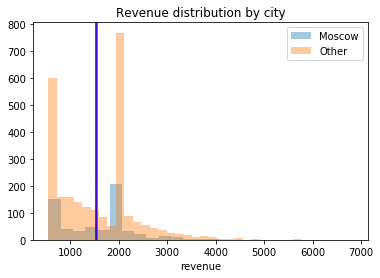

In [70]:
for city in ['Moscow', 'Other']:
    sns.distplot(revenue_by_city.query('city_agg == @city')['revenue'],label=city, kde=False)
    plt.legend(['Moscow', 'Other'])
    plt.title('Revenue distribution by city');

plt.axvline(revenue_by_city.query('city_agg == "Moscow"')['revenue'].mean(), c='red');
plt.axvline(revenue_by_city.query('city_agg == "Other"')['revenue'].mean(), c='blue');
plt.show()

На графике мы видим, что и у пользователей из Москвы, и у пользователей из других регионов наблюдается по 2 пика, эти пики расположены на уровне минимальной абонентской платы по двум разным тарифам. 

На графике наглядно видно, что количество пользователей из Москвы в нашей выборке значительно меньше, чем пользователей из других регионов.

Синяя и красная линия, которые показывают среднее значение выручки пользователей в Москве (красная линия) и в других регионах (синяя линия), практически сливаются на уровне 1550 руб. Однако то, что средние значения в наших выборках так на первый взгляд похожи, мы не можем говорить о том, что разницы между выручкой в завимости от города нет. Для этого нам необходимо провести тест.

In [71]:
(revenue_by_city
         .pivot_table(index='city_agg',values='revenue',aggfunc=({'sum','count','mean','median'}))
)

,count,mean,median,sum
city_agg,,,,
Moscow,611,1561.22,1776.00,953906.00
Other,2605,1540.95,1632.00,4014184.00


In [72]:
moscow = revenue_by_city.query('city_agg == "Moscow"')['revenue']
other = revenue_by_city.query('city_agg == "Other"')['revenue']

In [73]:
alpha = .05

In [74]:
results_by_city = st.ttest_ind(
    moscow, 
    other
)

In [75]:
print('p-значение:',(results_by_city.pvalue))
if (results_by_city.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5746021529115002
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средние значения выручки пользователей Москвы и других регионов отличаются, однако с вероятностью 58% такое или большее различие можно получить случайно при том, что **нулевая гипотеза верна**. На основании проведенного теста нельзя делать вывод о значимом различии между средними значениями.

## Вывод

В данном шаге были проверены две гипотезы, касающиеся выручки компании от пользователей из выборки: 

**1) Выручка пользователей тарифов "Смарт" и "Ультра" равна.**  
    
   При уровне значимости, равном 5% данная гипотеза была отвергнута. Различия между средними значениями выручки в зависимости от тарифа могут считаться статистически достоверными.
    
   Средняя выручка для тарифа "Смарт" составляет 1300 руб., для тарифа "Ультра" - 2070 руб. Если для тарифа "Ультра" это значение лишь незначительно превышает минимальную абонентскую плату (на 6%), то для тарифа "Смарт" средняя выручка значительно превышает минимальную плату (на 136%).
    
 **2) Выручка пользователей из Москвы и из других регионов равна.**  
 
   При уровне значимости, равном 5% данная гипотеза не можеть быть отвергнута. С вероятностью 58% различия в средней выручке могут быть получены случайно.
   
   Средняя выручка для пользователей из Москвы составила 1560 руб., для пользователей из других регионов - 1540 руб.

# Шаг 5. Общий вывод <a name="5step"></a>

Имея в распоряжении данные о поведении 500 пользователей двух тарифов компании "Мегалайн", мы смогли провести предварительный анализ этих данных и проверить на их основании гипотезы.

Для коммерческого департамента, который поставил перед нами задачу, важно понять, какой тариф приносит больше денег. Впоследствии эти данные будут использованы для корректировки рекламного бюджета. Вероятно одним из потенциальных решений коммерческого депаратамента будет снижение расходов на рекламу более дешевого тарифа в пользу более дорогого тарифа.

#### Проведенный нами анализ тарифа "Смарт" показал, что:
   1) Тарифом "Смарт" в течение 2018 года пользовалось 70% клиентов  
   2) Месячная выручка от данного тарифа на 136% превышает минимальную абонентскую плату за тариф, поскольку пользователям недостаточно предоставленного объема услуг в рамках пакета  
   3) Среднее значение выручки по тарифу "Смарт" составляет 1313 руб., медиана - 1077 руб.

#### Что касается тарифа "Ультра":  
   1) Тарифом "Ультра" в 2018 году пользовались остальные 30% клиентов  
   2) Месячная средняя выручка от данного тарифа составляет 2070 руб., что на 60% больше, чем для тарифа "Смарт" и всего на 6% выше минимальной абоненсткой платы  
   3) Для пользователей данного тарифа объем звонков и сообщений даже превышает спрос, но не для всех пользователей достаточен объем интернета. Как было выявлено при анализе тарифов, для пользователей тарифа "Ультра" скорее важно иметь большой пакет и не беспокоиться о превышении лимита, при этом он может не использовать предоставленный пакет и на половину  
   4) Среднее значение выручки тарифа "Ультра" составляет 2071 руб., при этом медиана равна абоненсткой плате - 1950 руб. 

#### Результаты проверки гипотез:

Проверка гипотез показала, что разница между выручкой по тарифам "Смарт" и "Ультра" статистически значимая при уровне значимости 5%. При этом разница в средней выручке от пользователей в Москве и в других регионов напротив, не является статистически значимой.

#### Какой тариф лучше?

Итак, какой же тариф лучше? Если под "лучше" понимать выгоднее в плане выручки, то несомненно ответ - тариф "Ультра". Однако нужно учитывать, что доля пользователей в тарифе "Ультра" составляет всего 30%. Для пользователей может быть психологически сложно платить высокую абоненсткую плату, как в тарифе "Ультра". Возможно наоборот пользователь выбирает тариф "Смарт" из-за низкой абоненсткой платы и рассчитывает на то, что ему будет достаточно лимита по этому тарифу. Если всем пользователям тарифа "Смарт" навязать тариф "Ультра", то скорее всего часть этих пользователей перейдет к конкуренту. 

#### Несколько рекомендаций по результатам исследования:

   1) Провести работу с теми клиентам тарифа "Смарт", которые регулярно значительно превышают лимиты пакета, предложить им перейти на тариф "Ультра".
   
   2) Направить бОльшую часть бюджета на рекламу тарифа "Ультра", сделать акцент на том, что в рамках данного тарифа пользователь будет чувствать себя более свободно в использовании своего пакета и не задумываться о лимитах.  
   
   3) Однако оставить часть бюджета на рекламу тарифа "Смарт", поскольку не для всех пользователей тариф "Ультра" будет выгодным и психологически доступным.